http://cognitivemedium.com/rmnist

CNN:
- RMNIST/1: 56.91%
- RMNIST/5: 76.65%
- RMNIST/10: 86.53%
- MNIST: 99.11%

With data transformations:
- RMNIST/1: 55.25%
- RMNIST/5: 84.38%
- RMNIST/10: 92.07%
- MNIST: 99.34%

With transfer learning:
- RMNIST/1: 51.01%
- RMNIST/5: 72.81%
- RMNIST/10: 82.95%

With transfer learning and data transformations:
- RMNIST/1: 52.84%
- RMNIST/5: 75.27%
- RMNIST/10: 84.66%

In [1]:
import data_utils

In [2]:
trX, teX, trY, teY = data_utils.load_mnist(one_hot=False)

In [3]:
print(trX.shape)
print(trX.dtype)

(60000, 784)
float64


In [4]:
print(trY.shape)
print(teY.dtype)
print(type(trY))

(60000,)
uint8
<class 'numpy.ndarray'>


In [5]:
"""import random
import numpy as np
from collections import defaultdict

N = 10

counts = defaultdict(int) #need to keep track of how many of each digit
indices = list(range(50000))
random.shuffle(indices)

valX, valY = trX[50000:], trY[50000:]
rtrX, rtrY = np.zeros((N*10,784)), np.zeros((N*10), dtype=np.int32)
     
i = 0
for index in indices:
    if counts[trY[index]] < N:
        rtrX[i], rtrY[i] = trX[index], trY[index]
        counts[trY[index]] += 1
        i += 1"""

'import random\nimport numpy as np\nfrom collections import defaultdict\n\nN = 10\n\ncounts = defaultdict(int) #need to keep track of how many of each digit\nindices = list(range(50000))\nrandom.shuffle(indices)\n\nvalX, valY = trX[50000:], trY[50000:]\nrtrX, rtrY = np.zeros((N*10,784)), np.zeros((N*10), dtype=np.int32)\n     \ni = 0\nfor index in indices:\n    if counts[trY[index]] < N:\n        rtrX[i], rtrY[i] = trX[index], trY[index]\n        counts[trY[index]] += 1\n        i += 1'

5


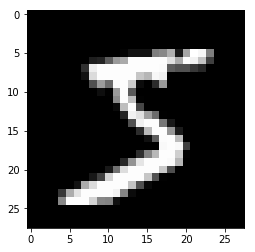

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

#view data

plt.imshow(trX[0].reshape(28,28), cmap=plt.get_cmap('gray')); #need cmap thing or else is weird colour
print(trY[0])

In [7]:
import numpy as np

def random_shift(X, max_shift=3):

    X = np.copy(X)
    
    n_pixels = np.random.randint(0,max_shift+1,4) #args are low, max, n, with max being exclusive, i.e. 0, 5, 4 produces 4 numbers between 0 and 4
    
    #shifting image up by n_pixels
    if n_pixels[0]:
        X[:-n_pixels[0]*28] = X[n_pixels[0]*28:]
        X[-n_pixels[0]*28:] = np.zeros(n_pixels[0]*28)
        
    #shifting image right by n_pixels
    if n_pixels[1]:
        X = X.reshape(28,28)
        X[:,n_pixels[1]:] = X[:,:-n_pixels[1]]
        X[:,:n_pixels[1]] = np.zeros((28,n_pixels[1]))
        X = X.reshape(28*28)
        
    #shifting image down by n_pixels
    if n_pixels[2]:
        X[n_pixels[2]*28:] = X[:-n_pixels[2]*28]
        X[:n_pixels[2]*28] = np.zeros(n_pixels[2]*28)
        
    #shifting image left by n_pixels
    if n_pixels[3]:
        X = X.reshape(28,28)
        X[:,:-n_pixels[3]] = X[:,n_pixels[3]:]
        X[:,-n_pixels[3]:] = np.zeros((28,n_pixels[3]))
        X = X.reshape(28*28)
    
    return X

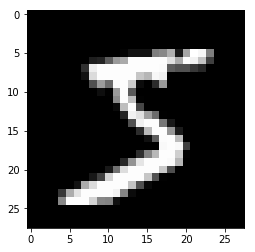

In [8]:
plt.imshow(trX[0].reshape(28,28), cmap=plt.get_cmap('gray')); #need cmap thing or else is weird colour

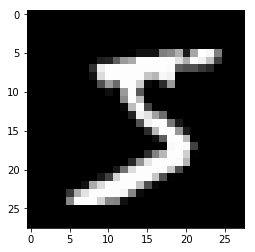

In [9]:
plt.imshow(random_shift(trX[0]).reshape(28,28), cmap=plt.get_cmap('gray')); #need cmap thing or else is weird colour

In [10]:
import torch
from torch.utils.data import Dataset

class MNIST(Dataset):
    
    def __init__(self, X, y, shift=None):
        assert len(X) == len(y)
        self.X = X
        self.y = y
        self.shift = shift
   
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]
        if self.shift:
            img = self.shift(img)
        img = img.reshape(28, 28)
        img = torch.Tensor(img)
        label = torch.from_numpy(np.array([label])).long()
        return (img, label)

In [ ]:
batch_size = 10

train_dataset = MNIST(trX, trY)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_dataset = MNIST(teX, teY)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)"""
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100,10)
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [13]:
model = Net()

lr = 0.1
momentum = 0
epochs = 200

In [14]:
from torch.autograd import Variable
import torch.optim as optim

def train(model, epoch):
    
    optimizer = optim.SGD(model.parameters(), lr=lr*((0.8)**(epoch/10+1)), momentum=momentum)
    
    model.train()
    
    for i, (X, y) in enumerate(train_loader):
        
        X, y = Variable(X), Variable(y)
        optimizer.zero_grad()
        output = model(X)
        loss = F.nll_loss(output, y.squeeze(1))
        loss.backward()
        optimizer.step()

In [15]:
def predict(model):
    
    model.eval()
    
    correct = 0
    
    for i, (X, y) in enumerate(val_loader):
        
        X, y = Variable(X), y.squeeze(1)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        #print(X)
        #print(y)
        #print(predicted)
        batch_correct = (predicted == y).sum()
        #print(X.size())
        #print(batch_correct)
        correct += batch_correct
        
    return correct/len(val_loader)*batch_size

In [16]:
for epoch in range(1, epochs+1):
    
    train(model, epoch)
    acc = predict(model)
    print(f'Epoch: {epoch}, Acc: {acc}')

Epoch: 1, Acc: 95.88
Epoch: 2, Acc: 95.82000000000001
Epoch: 3, Acc: 97.33000000000001
Epoch: 4, Acc: 97.49000000000001
Epoch: 5, Acc: 97.44999999999999
Epoch: 6, Acc: 97.10000000000001
Epoch: 7, Acc: 97.66999999999999
Epoch: 8, Acc: 97.55000000000001
Epoch: 9, Acc: 97.60999999999999


KeyboardInterrupt: 